# Histopathologic Cancer Detection
# A deep learning approach to detect metastatic cancer in tissue images


In [1]:

## Import necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import transforms, models

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix

from PIL import Image


In [2]:

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

# Check if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cpu


In [3]:

## Data Loading and Preprocessing

# Define paths (adjust according to your setup)
base_dir = './'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')
train_labels_path = os.path.join(base_dir, 'train_labels.csv')

# Load the training labels
train_df = pd.read_csv(train_labels_path)
print(f"Training data shape: {train_df.shape}")
print(train_df.head())


Training data shape: (220025, 2)
                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0


Class distribution:
label
0    130908
1     89117
Name: count, dtype: int64
Percentage of positive cases: 40.50%


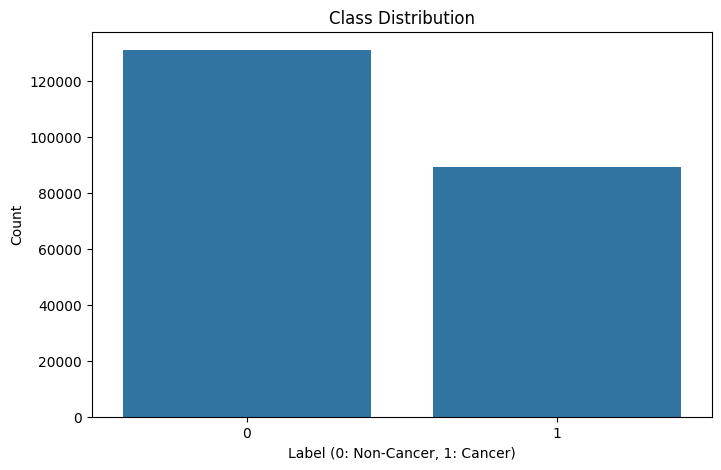

In [4]:

# Check class distribution
print("Class distribution:")
print(train_df['label'].value_counts())
print(f"Percentage of positive cases: {train_df['label'].mean() * 100:.2f}%")

# Visualize class distribution
plt.figure(figsize=(8, 5))
sns.countplot(x='label', data=train_df)
plt.title('Class Distribution')
plt.xlabel('Label (0: Non-Cancer, 1: Cancer)')
plt.ylabel('Count')
plt.show()


In [5]:

# Custom Dataset class for the histopathologic images
class CancerDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df
        self.img_dir = img_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img_id = self.df.iloc[idx, 0]
        img_path = os.path.join(self.img_dir, f"{img_id}.tif")
        image = Image.open(img_path)
        
        if self.transform:
            image = self.transform(image)
        
        if len(self.df.columns) > 1:  # If we have labels
            label = self.df.iloc[idx, 1]
            return image, label
        else:
            return image, img_id


In [6]:

# Define transformations
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Split data into training and validation sets
train_data, val_data = train_test_split(train_df, test_size=0.2, random_state=42, stratify=train_df['label'])
print(f"Training set size: {len(train_data)}")
print(f"Validation set size: {len(val_data)}")


Training set size: 176020
Validation set size: 44005


In [7]:

# Create datasets
train_dataset = CancerDataset(train_data, train_dir, transform=train_transform)
val_dataset = CancerDataset(val_data, train_dir, transform=val_transform)

# Create dataloaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)


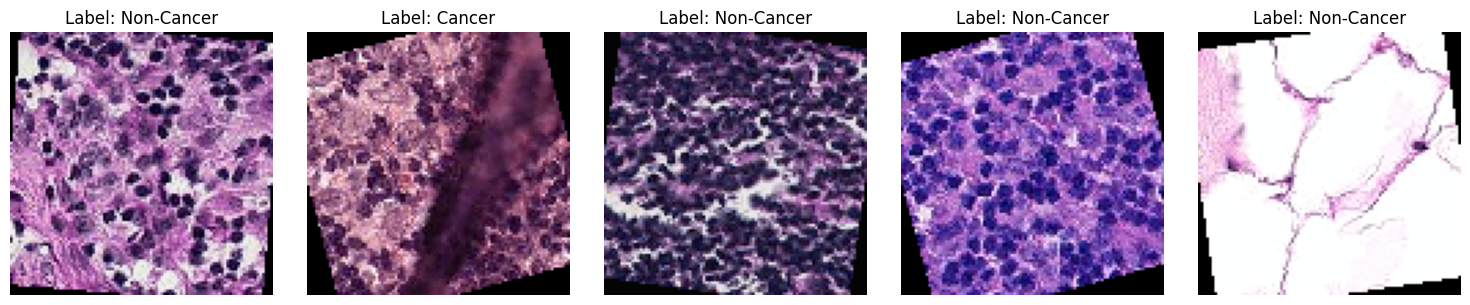

In [8]:

# Visualize some training examples
def visualize_samples(dataset, num_samples=5):
    plt.figure(figsize=(15, 3))
    for i in range(num_samples):
        image, label = dataset[np.random.randint(0, len(dataset))]
        image = image.numpy().transpose((1, 2, 0))
        # Denormalize the image for visualization
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)
        
        plt.subplot(1, num_samples, i+1)
        plt.imshow(image)
        plt.title(f"Label: {'Cancer' if label == 1 else 'Non-Cancer'}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

visualize_samples(train_dataset)



## Model Definition

In [9]:

# Define the CNN model (using a pre-trained ResNet18 as the base)
class CancerClassifier(nn.Module):
    def __init__(self, pretrained=True):
        super(CancerClassifier, self).__init__()
        # Use pretrained ResNet18
        self.resnet = models.resnet18(pretrained=pretrained)
        # Replace the final fully connected layer
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(num_ftrs, 1)
        )
        
    def forward(self, x):
        x = self.resnet(x)
        return x

model = CancerClassifier(pretrained=True).to(device)
print(model)


c:\Users\antoi\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\antoi\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


CancerClassifier(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, t

In [10]:

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=3e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3, verbose=True)


c:\Users\antoi\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



## Training Function

In [11]:

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=10):
    history = {
        'train_loss': [], 'val_loss': [],
        'train_acc': [], 'val_acc': [],
        'val_auc': []
    }
    
    best_val_auc = 0.0
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):
            inputs = inputs.to(device)
            labels = labels.float().to(device).view(-1, 1)
            
            optimizer.zero_grad()
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            predicted = torch.sigmoid(outputs) >= 0.5
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        epoch_train_loss = running_loss / total
        epoch_train_acc = correct / total
        
        # Validation phase
        model.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        all_labels = []
        all_probs = []
        
        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]"):
                inputs = inputs.to(device)
                labels = labels.float().to(device).view(-1, 1)
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                running_loss += loss.item() * inputs.size(0)
                probabilities = torch.sigmoid(outputs)
                predicted = probabilities >= 0.5
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                
                # Collect for AUC calculation
                all_labels.extend(labels.cpu().numpy())
                all_probs.extend(probabilities.cpu().numpy())
        
        epoch_val_loss = running_loss / total
        epoch_val_acc = correct / total
        epoch_val_auc = roc_auc_score(all_labels, all_probs)
        
        # Update learning rate based on validation AUC
        scheduler.step(epoch_val_auc)
        
        # Save history
        history['train_loss'].append(epoch_train_loss)
        history['val_loss'].append(epoch_val_loss)
        history['train_acc'].append(epoch_train_acc)
        history['val_acc'].append(epoch_val_acc)
        history['val_auc'].append(epoch_val_auc)
        
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f}")
        print(f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f}, Val AUC: {epoch_val_auc:.4f}")
        
        # Save best model
        if epoch_val_auc > best_val_auc:
            best_val_auc = epoch_val_auc
            torch.save(model.state_dict(), 'best_model.pth')
            print("Saved best model!")
        
        print("-" * 60)
    
    return history


## Train the model

In [ ]:
num_epochs = 10
history = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=num_epochs)

# Plot training history
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curves')

plt.subplot(1, 3, 2)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Curves')

plt.subplot(1, 3, 3)
plt.plot(history['val_auc'], label='Val AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()
plt.title('AUC Curve')

plt.tight_layout()
plt.show()


Epoch 1/10 [Train]:   0%|          | 0/5501 [00:00<?, ?it/s]

In [ ]:

## Evaluate on Validation Set
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

all_labels = []
all_preds = []
all_probs = []

with torch.no_grad():
    for inputs, labels in tqdm(val_loader, desc="Evaluating"):
        inputs = inputs.to(device)
        labels = labels.float().to(device).view(-1, 1)
        
        outputs = model(inputs)
        probabilities = torch.sigmoid(outputs)
        predicted = (probabilities >= 0.5).int()
        
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())
        all_probs.extend(probabilities.cpu().numpy())

# Calculate metrics
val_accuracy = accuracy_score(all_labels, all_preds)
val_auc = roc_auc_score(all_labels, all_probs)
conf_matrix = confusion_matrix(all_labels, all_preds)

print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Validation AUC: {val_auc:.4f}")
print("Confusion Matrix:")
print(conf_matrix)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Non-Cancer', 'Cancer'], 
            yticklabels=['Non-Cancer', 'Cancer'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## Prepare submission for Kaggle

# Load test data
test_df = pd.DataFrame({'id': [os.path.splitext(f)[0] for f in os.listdir(test_dir) if f.endswith('.tif')]})
test_dataset = CancerDataset(test_df, test_dir, transform=val_transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# Make predictions on test set
test_predictions = []
test_ids = []

model.eval()
with torch.no_grad():
    for inputs, ids in tqdm(test_loader, desc="Predicting on test set"):
        inputs = inputs.to(device)
        outputs = model(inputs)
        probabilities = torch.sigmoid(outputs).cpu().numpy()
        
        test_predictions.extend(probabilities)
        test_ids.extend(ids)

# Create submission file
submission_df = pd.DataFrame({
    'id': test_ids,
    'label': test_predictions
})
submission_df.to_csv('submission.csv', index=False)
print("Submission file created!")

## Error Analysis

# Find misclassified examples
misclassified_indices = []
model.eval()

with torch.no_grad():
    for i, (inputs, labels) in enumerate(val_loader):
        inputs = inputs.to(device)
        labels = labels.float().to(device).view(-1, 1)
        
        outputs = model(inputs)
        probabilities = torch.sigmoid(outputs)
        predicted = (probabilities >= 0.5).int()
        
        for j in range(inputs.size(0)):
            if predicted[j] != labels[j]:
                # Get the actual index in the validation dataset
                misclassified_indices.append(i * batch_size + j)

# Visualize some misclassified examples
def visualize_misclassified(dataset, indices, num_samples=5):
    plt.figure(figsize=(15, 6))
    for i, idx in enumerate(indices[:num_samples]):
        image, label = dataset[idx]
        image = image.numpy().transpose((1, 2, 0))
        # Denormalize the image
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)
        
        plt.subplot(1, num_samples, i+1)
        plt.imshow(image)
        plt.title(f"True: {'Cancer' if label == 1 else 'Non-Cancer'}\nPred: {'Cancer' if label == 0 else 'Non-Cancer'}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

if misclassified_indices:
    visualize_misclassified(val_dataset, misclassified_indices)
else:
    print("No misclassified examples found")

## Feature Visualization with Grad-CAM

# Grad-CAM implementation for visualizing what the model focuses on
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        
        # Register hooks
        target_layer.register_forward_hook(self.forward_hook)
        target_layer.register_full_backward_hook(self.backward_hook)
    
    def forward_hook(self, module, input, output):
        self.activations = output.detach()
    
    def backward_hook(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()
    
    def generate_cam(self, input_image, target_class=None):
        # Forward pass
        model_output = self.model(input_image)
        
        if target_class is None:
            target_class = torch.argmax(model_output)
        
        # Zero gradients
        self.model.zero_grad()
        
        # Backward pass with the target class
        model_output[0, target_class].backward()
        
        # Get weights
        weights = torch.mean(self.gradients, dim=(2, 3), keepdim=True)
        
        # Generate CAM
        cam = torch.sum(weights * self.activations, dim=1, keepdim=True)
        cam = F.relu(cam)  # Apply ReLU to focus on features that have a positive influence
        
        # Normalize CAM
        cam = F.interpolate(cam, size=input_image.shape[2:], mode='bilinear', align_corners=False)
        cam = cam - cam.min()
        if cam.max() > 0:
            cam = cam / cam.max()
        
        return cam.squeeze().cpu().numpy()

# Function to visualize Grad-CAM
def visualize_gradcam(model, dataset, indices, num_samples=3):
    # Get the last convolutional layer in ResNet
    target_layer = model.resnet.layer4[-1].conv2
    grad_cam = GradCAM(model, target_layer)
    
    model.eval()
    plt.figure(figsize=(15, 5 * num_samples))
    
    for i, idx in enumerate(indices[:num_samples]):
        image, label = dataset[idx]
        input_tensor = image.unsqueeze(0).to(device)
        
        with torch.no_grad():
            output = model(input_tensor)
            prob = torch.sigmoid(output).item()
        
        # Generate CAM
        cam = grad_cam.generate_cam(input_tensor, target_class=0)  # For binary classification
        
        # Convert image for visualization
        image = image.numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)
        
        # Original image
        plt.subplot(num_samples, 3, i*3 + 1)
        plt.imshow(image)
        plt.title(f"True: {'Cancer' if label == 1 else 'Non-Cancer'}\nPred: {prob:.4f}")
        plt.axis('off')
        
        # Heatmap
        plt.subplot(num_samples, 3, i*3 + 2)
        plt.imshow(cam, cmap='jet')
        plt.title('Grad-CAM')
        plt.axis('off')
        
        # Overlay
        plt.subplot(num_samples, 3, i*3 + 3)
        plt.imshow(image)
        plt.imshow(cam, cmap='jet', alpha=0.5)
        plt.title('Overlay')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize correctly classified examples
correct_indices = []
with torch.no_grad():
    for i, (inputs, labels) in enumerate(val_loader):
        inputs = inputs.to(device)
        labels = labels.float().to(device).view(-1, 1)
        
        outputs = model(inputs)
        probabilities = torch.sigmoid(outputs)
        predicted = (probabilities >= 0.5).int()
        
        for j in range(inputs.size(0)):
            if predicted[j] == labels[j]:
                # Get the actual index in the validation dataset
                correct_indices.append(i * batch_size + j)
                if len(correct_indices) >= 3:  # Just need a few examples
                    break
        if len(correct_indices) >= 3:
            break

# Visualize with Grad-CAM
print("Correctly classified examples with Grad-CAM:")
visualize_gradcam(model, val_dataset, correct_indices)

if misclassified_indices:
    print("Misclassified examples with Grad-CAM:")
    visualize_gradcam(model, val_dataset, misclassified_indices)

## K-Fold Cross Validation (Optional)
# This is commented out because it's computationally expensive but would provide more robust model evaluation

"""
from sklearn.model_selection import KFold

def kfold_cross_validation(df, n_splits=5, epochs=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    fold_results = []
    
    for fold, (train_idx, val_idx) in enumerate(kf.split(df)):
        print(f"\n{'='*30} Fold {fold+1}/{n_splits} {'='*30}")
        
        train_data = df.iloc[train_idx].reset_index(drop=True)
        val_data = df.iloc[val_idx].reset_index(drop=True)
        
        train_dataset = CancerDataset(train_data, train_dir, transform=train_transform)
        val_dataset = CancerDataset(val_data, train_dir, transform=val_transform)
        
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
        
        model = CancerClassifier(pretrained=True).to(device)
        criterion = nn.BCEWithLogitsLoss()
        optimizer = optim.Adam(model.parameters(), lr=3e-4)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3, verbose=True)
        
        history = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=epochs)
        
        # Get final validation metrics
        model.load_state_dict(torch.load('best_model.pth'))
        model.eval()
        
        all_labels = []
        all_probs = []
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.float().to(device).view(-1, 1)
                
                outputs = model(inputs)
                probabilities = torch.sigmoid(outputs)
                
                all_labels.extend(labels.cpu().numpy())
                all_probs.extend(probabilities.cpu().numpy())
        
        val_auc = roc_auc_score(all_labels, all_probs)
        fold_results.append(val_auc)
        
        print(f"Fold {fold+1} - Validation AUC: {val_auc:.4f}")
    
    print("\nK-Fold Cross-Validation Results:")
    for fold, result in enumerate(fold_results):
        print(f"Fold {fold+1}: AUC = {result:.4f}")
    print(f"Mean AUC: {np.mean(fold_results):.4f} ± {np.std(fold_results):.4f}")

# Run K-fold cross-validation (commented out due to computational cost)
# kfold_cross_validation(train_df, n_splits=5, epochs=5)
"""

## Model Ensembling (Optional)
# Using multiple models can improve performance

"""
# Assuming we have trained multiple models from different folds or with different architectures
def ensemble_predictions(models, data_loader):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    all_predictions = []
    all_ids = []
    
    for model in models:
        model.eval()
        model_predictions = []
        ids = []
        
        with torch.no_grad():
            for inputs, batch_ids in tqdm(data_loader):
                inputs = inputs.to(device)
                outputs = model(inputs)
                probabilities = torch.sigmoid(outputs).cpu().numpy()
                
                model_predictions.extend(probabilities)
                if len(all_ids) < len(data_loader.dataset):  # Only collect IDs once
                    ids.extend(batch_ids)
        
        all_predictions.append(model_predictions)
        if len(all_ids) < len(data_loader.dataset):
            all_ids = ids
    
    # Average predictions from all models
    ensemble_preds = np.mean(all_predictions, axis=0)
    
    return ensemble_preds, all_ids

# Example of using ensembling (commented out as we haven't trained multiple models yet)
# models = [model1, model2, model3]  # Different trained models
# ensemble_preds, test_ids = ensemble_predictions(models, test_loader)
# submission_df = pd.DataFrame({'id': test_ids, 'label': ensemble_preds})
# submission_df.to_csv('ensemble_submission.csv', index=False)
"""

## Conclusion

"""
In this notebook, we've built and trained a deep learning model to detect metastatic cancer in histopathologic images. Here's a summary of what we did:

1. Data Exploration: We analyzed the dataset and visualized examples of cancer and non-cancer tissues.

2. Model Development: We used a pre-trained ResNet18 architecture and fine-tuned it for our binary classification task.

3. Training and Evaluation: We trained the model for 10 epochs with data augmentation and early stopping based on validation AUC.

4. Error Analysis: We examined misclassified examples to understand the model's limitations.

5. Model Interpretation: We used Grad-CAM to visualize which parts of the images the model focuses on when making predictions.

6. Prediction: We generated predictions on the test set for submission to Kaggle.

Best practices used:
- Data augmentation to prevent overfitting
- Transfer learning with a pre-trained model
- Model validation with appropriate metrics (accuracy, AUC)
- Learning rate scheduling
- Error analysis and model interpretability

Future improvements:
- Experiment with different architectures (ResNet50, EfficientNet)
- Use more advanced augmentation techniques
- Implement test-time augmentation (TTA)
- Try ensemble methods with multiple models
- Hyperparameter tuning
"""

In [ ]:

## Import necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import transforms, models

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix

from PIL import Image

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

# Check if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

## Data Loading and Preprocessing

# Define paths (adjust according to your setup)
base_dir = '/kaggle/input/histopathologic-cancer-detection/'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')
train_labels_path = os.path.join(base_dir, 'train_labels.csv')

# Load the training labels
train_df = pd.read_csv(train_labels_path)
print(f"Training data shape: {train_df.shape}")
print(train_df.head())

# Check class distribution
print("Class distribution:")
print(train_df['label'].value_counts())
print(f"Percentage of positive cases: {train_df['label'].mean() * 100:.2f}%")

# Visualize class distribution
plt.figure(figsize=(8, 5))
sns.countplot(x='label', data=train_df)
plt.title('Class Distribution')
plt.xlabel('Label (0: Non-Cancer, 1: Cancer)')
plt.ylabel('Count')
plt.show()

# Custom Dataset class for the histopathologic images
class CancerDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df
        self.img_dir = img_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img_id = self.df.iloc[idx, 0]
        img_path = os.path.join(self.img_dir, f"{img_id}.tif")
        image = Image.open(img_path)
        
        if self.transform:
            image = self.transform(image)
        
        if len(self.df.columns) > 1:  # If we have labels
            label = self.df.iloc[idx, 1]
            return image, label
        else:
            return image, img_id

# Define transformations
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Split data into training and validation sets
train_data, val_data = train_test_split(train_df, test_size=0.2, random_state=42, stratify=train_df['label'])
print(f"Training set size: {len(train_data)}")
print(f"Validation set size: {len(val_data)}")

# Create datasets
train_dataset = CancerDataset(train_data, train_dir, transform=train_transform)
val_dataset = CancerDataset(val_data, train_dir, transform=val_transform)

# Create dataloaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# Visualize some training examples
def visualize_samples(dataset, num_samples=5):
    plt.figure(figsize=(15, 3))
    for i in range(num_samples):
        image, label = dataset[np.random.randint(0, len(dataset))]
        image = image.numpy().transpose((1, 2, 0))
        # Denormalize the image for visualization
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)
        
        plt.subplot(1, num_samples, i+1)
        plt.imshow(image)
        plt.title(f"Label: {'Cancer' if label == 1 else 'Non-Cancer'}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

visualize_samples(train_dataset)

## Model Definition

# Define the CNN model (using a pre-trained ResNet18 as the base)
class CancerClassifier(nn.Module):
    def __init__(self, pretrained=True):
        super(CancerClassifier, self).__init__()
        # Use pretrained ResNet18
        self.resnet = models.resnet18(pretrained=pretrained)
        # Replace the final fully connected layer
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(num_ftrs, 1)
        )
        
    def forward(self, x):
        x = self.resnet(x)
        return x

model = CancerClassifier(pretrained=True).to(device)
print(model)

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=3e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3, verbose=True)

## Training Function

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=10):
    history = {
        'train_loss': [], 'val_loss': [],
        'train_acc': [], 'val_acc': [],
        'val_auc': []
    }
    
    best_val_auc = 0.0
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):
            inputs = inputs.to(device)
            labels = labels.float().to(device).view(-1, 1)
            
            optimizer.zero_grad()
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            predicted = torch.sigmoid(outputs) >= 0.5
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        epoch_train_loss = running_loss / total
        epoch_train_acc = correct / total
        
        # Validation phase
        model.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        all_labels = []
        all_probs = []
        
        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]"):
                inputs = inputs.to(device)
                labels = labels.float().to(device).view(-1, 1)
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                running_loss += loss.item() * inputs.size(0)
                probabilities = torch.sigmoid(outputs)
                predicted = probabilities >= 0.5
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                
                # Collect for AUC calculation
                all_labels.extend(labels.cpu().numpy())
                all_probs.extend(probabilities.cpu().numpy())
        
        epoch_val_loss = running_loss / total
        epoch_val_acc = correct / total
        epoch_val_auc = roc_auc_score(all_labels, all_probs)
        
        # Update learning rate based on validation AUC
        scheduler.step(epoch_val_auc)
        
        # Save history
        history['train_loss'].append(epoch_train_loss)
        history['val_loss'].append(epoch_val_loss)
        history['train_acc'].append(epoch_train_acc)
        history['val_acc'].append(epoch_val_acc)
        history['val_auc'].append(epoch_val_auc)
        
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f}")
        print(f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f}, Val AUC: {epoch_val_auc:.4f}")
        
        # Save best model
        if epoch_val_auc > best_val_auc:
            best_val_auc = epoch_val_auc
            torch.save(model.state_dict(), 'best_model.pth')
            print("Saved best model!")
        
        print("-" * 60)
    
    return history

## Train the model
num_epochs = 10
history = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=num_epochs)

## Plot training history
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curves')

plt.subplot(1, 3, 2)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Curves')

plt.subplot(1, 3, 3)
plt.plot(history['val_auc'], label='Val AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()
plt.title('AUC Curve')

plt.tight_layout()
plt.show()

## Evaluate on Validation Set
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

all_labels = []
all_preds = []
all_probs = []

with torch.no_grad():
    for inputs, labels in tqdm(val_loader, desc="Evaluating"):
        inputs = inputs.to(device)
        labels = labels.float().to(device).view(-1, 1)
        
        outputs = model(inputs)
        probabilities = torch.sigmoid(outputs)
        predicted = (probabilities >= 0.5).int()
        
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())
        all_probs.extend(probabilities.cpu().numpy())

# Calculate metrics
val_accuracy = accuracy_score(all_labels, all_preds)
val_auc = roc_auc_score(all_labels, all_probs)
conf_matrix = confusion_matrix(all_labels, all_preds)

print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Validation AUC: {val_auc:.4f}")
print("Confusion Matrix:")
print(conf_matrix)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Non-Cancer', 'Cancer'], 
            yticklabels=['Non-Cancer', 'Cancer'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## Prepare submission for Kaggle

# Load test data
test_df = pd.DataFrame({'id': [os.path.splitext(f)[0] for f in os.listdir(test_dir) if f.endswith('.tif')]})
test_dataset = CancerDataset(test_df, test_dir, transform=val_transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# Make predictions on test set
test_predictions = []
test_ids = []

model.eval()
with torch.no_grad():
    for inputs, ids in tqdm(test_loader, desc="Predicting on test set"):
        inputs = inputs.to(device)
        outputs = model(inputs)
        probabilities = torch.sigmoid(outputs).cpu().numpy()
        
        test_predictions.extend(probabilities)
        test_ids.extend(ids)

# Create submission file
submission_df = pd.DataFrame({
    'id': test_ids,
    'label': test_predictions
})
submission_df.to_csv('submission.csv', index=False)
print("Submission file created!")

## Error Analysis

# Find misclassified examples
misclassified_indices = []
model.eval()

with torch.no_grad():
    for i, (inputs, labels) in enumerate(val_loader):
        inputs = inputs.to(device)
        labels = labels.float().to(device).view(-1, 1)
        
        outputs = model(inputs)
        probabilities = torch.sigmoid(outputs)
        predicted = (probabilities >= 0.5).int()
        
        for j in range(inputs.size(0)):
            if predicted[j] != labels[j]:
                # Get the actual index in the validation dataset
                misclassified_indices.append(i * batch_size + j)

# Visualize some misclassified examples
def visualize_misclassified(dataset, indices, num_samples=5):
    plt.figure(figsize=(15, 6))
    for i, idx in enumerate(indices[:num_samples]):
        image, label = dataset[idx]
        image = image.numpy().transpose((1, 2, 0))
        # Denormalize the image
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)
        
        plt.subplot(1, num_samples, i+1)
        plt.imshow(image)
        plt.title(f"True: {'Cancer' if label == 1 else 'Non-Cancer'}\nPred: {'Cancer' if label == 0 else 'Non-Cancer'}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

if misclassified_indices:
    visualize_misclassified(val_dataset, misclassified_indices)
else:
    print("No misclassified examples found")

## Feature Visualization with Grad-CAM

# Grad-CAM implementation for visualizing what the model focuses on
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        
        # Register hooks
        target_layer.register_forward_hook(self.forward_hook)
        target_layer.register_full_backward_hook(self.backward_hook)
    
    def forward_hook(self, module, input, output):
        self.activations = output.detach()
    
    def backward_hook(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()
    
    def generate_cam(self, input_image, target_class=None):
        # Forward pass
        model_output = self.model(input_image)
        
        if target_class is None:
            target_class = torch.argmax(model_output)
        
        # Zero gradients
        self.model.zero_grad()
        
        # Backward pass with the target class
        model_output[0, target_class].backward()
        
        # Get weights
        weights = torch.mean(self.gradients, dim=(2, 3), keepdim=True)
        
        # Generate CAM
        cam = torch.sum(weights * self.activations, dim=1, keepdim=True)
        cam = F.relu(cam)  # Apply ReLU to focus on features that have a positive influence
        
        # Normalize CAM
        cam = F.interpolate(cam, size=input_image.shape[2:], mode='bilinear', align_corners=False)
        cam = cam - cam.min()
        if cam.max() > 0:
            cam = cam / cam.max()
        
        return cam.squeeze().cpu().numpy()

# Function to visualize Grad-CAM
def visualize_gradcam(model, dataset, indices, num_samples=3):
    # Get the last convolutional layer in ResNet
    target_layer = model.resnet.layer4[-1].conv2
    grad_cam = GradCAM(model, target_layer)
    
    model.eval()
    plt.figure(figsize=(15, 5 * num_samples))
    
    for i, idx in enumerate(indices[:num_samples]):
        image, label = dataset[idx]
        input_tensor = image.unsqueeze(0).to(device)
        
        with torch.no_grad():
            output = model(input_tensor)
            prob = torch.sigmoid(output).item()
        
        # Generate CAM
        cam = grad_cam.generate_cam(input_tensor, target_class=0)  # For binary classification
        
        # Convert image for visualization
        image = image.numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)
        
        # Original image
        plt.subplot(num_samples, 3, i*3 + 1)
        plt.imshow(image)
        plt.title(f"True: {'Cancer' if label == 1 else 'Non-Cancer'}\nPred: {prob:.4f}")
        plt.axis('off')
        
        # Heatmap
        plt.subplot(num_samples, 3, i*3 + 2)
        plt.imshow(cam, cmap='jet')
        plt.title('Grad-CAM')
        plt.axis('off')
        
        # Overlay
        plt.subplot(num_samples, 3, i*3 + 3)
        plt.imshow(image)
        plt.imshow(cam, cmap='jet', alpha=0.5)
        plt.title('Overlay')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize correctly classified examples
correct_indices = []
with torch.no_grad():
    for i, (inputs, labels) in enumerate(val_loader):
        inputs = inputs.to(device)
        labels = labels.float().to(device).view(-1, 1)
        
        outputs = model(inputs)
        probabilities = torch.sigmoid(outputs)
        predicted = (probabilities >= 0.5).int()
        
        for j in range(inputs.size(0)):
            if predicted[j] == labels[j]:
                # Get the actual index in the validation dataset
                correct_indices.append(i * batch_size + j)
                if len(correct_indices) >= 3:  # Just need a few examples
                    break
        if len(correct_indices) >= 3:
            break

# Visualize with Grad-CAM
print("Correctly classified examples with Grad-CAM:")
visualize_gradcam(model, val_dataset, correct_indices)

if misclassified_indices:
    print("Misclassified examples with Grad-CAM:")
    visualize_gradcam(model, val_dataset, misclassified_indices)

## K-Fold Cross Validation (Optional)
# This is commented out because it's computationally expensive but would provide more robust model evaluation

"""
from sklearn.model_selection import KFold

def kfold_cross_validation(df, n_splits=5, epochs=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    fold_results = []
    
    for fold, (train_idx, val_idx) in enumerate(kf.split(df)):
        print(f"\n{'='*30} Fold {fold+1}/{n_splits} {'='*30}")
        
        train_data = df.iloc[train_idx].reset_index(drop=True)
        val_data = df.iloc[val_idx].reset_index(drop=True)
        
        train_dataset = CancerDataset(train_data, train_dir, transform=train_transform)
        val_dataset = CancerDataset(val_data, train_dir, transform=val_transform)
        
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
        
        model = CancerClassifier(pretrained=True).to(device)
        criterion = nn.BCEWithLogitsLoss()
        optimizer = optim.Adam(model.parameters(), lr=3e-4)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3, verbose=True)
        
        history = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=epochs)
        
        # Get final validation metrics
        model.load_state_dict(torch.load('best_model.pth'))
        model.eval()
        
        all_labels = []
        all_probs = []
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.float().to(device).view(-1, 1)
                
                outputs = model(inputs)
                probabilities = torch.sigmoid(outputs)
                
                all_labels.extend(labels.cpu().numpy())
                all_probs.extend(probabilities.cpu().numpy())
        
        val_auc = roc_auc_score(all_labels, all_probs)
        fold_results.append(val_auc)
        
        print(f"Fold {fold+1} - Validation AUC: {val_auc:.4f}")
    
    print("\nK-Fold Cross-Validation Results:")
    for fold, result in enumerate(fold_results):
        print(f"Fold {fold+1}: AUC = {result:.4f}")
    print(f"Mean AUC: {np.mean(fold_results):.4f} ± {np.std(fold_results):.4f}")

# Run K-fold cross-validation (commented out due to computational cost)
# kfold_cross_validation(train_df, n_splits=5, epochs=5)
"""

## Model Ensembling (Optional)
# Using multiple models can improve performance

"""
# Assuming we have trained multiple models from different folds or with different architectures
def ensemble_predictions(models, data_loader):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    all_predictions = []
    all_ids = []
    
    for model in models:
        model.eval()
        model_predictions = []
        ids = []
        
        with torch.no_grad():
            for inputs, batch_ids in tqdm(data_loader):
                inputs = inputs.to(device)
                outputs = model(inputs)
                probabilities = torch.sigmoid(outputs).cpu().numpy()
                
                model_predictions.extend(probabilities)
                if len(all_ids) < len(data_loader.dataset):  # Only collect IDs once
                    ids.extend(batch_ids)
        
        all_predictions.append(model_predictions)
        if len(all_ids) < len(data_loader.dataset):
            all_ids = ids
    
    # Average predictions from all models
    ensemble_preds = np.mean(all_predictions, axis=0)
    
    return ensemble_preds, all_ids

# Example of using ensembling (commented out as we haven't trained multiple models yet)
# models = [model1, model2, model3]  # Different trained models
# ensemble_preds, test_ids = ensemble_predictions(models, test_loader)
# submission_df = pd.DataFrame({'id': test_ids, 'label': ensemble_preds})
# submission_df.to_csv('ensemble_submission.csv', index=False)
"""

## Conclusion

"""
In this notebook, we've built and trained a deep learning model to detect metastatic cancer in histopathologic images. Here's a summary of what we did:

1. Data Exploration: We analyzed the dataset and visualized examples of cancer and non-cancer tissues.

2. Model Development: We used a pre-trained ResNet18 architecture and fine-tuned it for our binary classification task.

3. Training and Evaluation: We trained the model for 10 epochs with data augmentation and early stopping based on validation AUC.

4. Error Analysis: We examined misclassified examples to understand the model's limitations.

5. Model Interpretation: We used Grad-CAM to visualize which parts of the images the model focuses on when making predictions.

6. Prediction: We generated predictions on the test set for submission to Kaggle.

Best practices used:
- Data augmentation to prevent overfitting
- Transfer learning with a pre-trained model
- Model validation with appropriate metrics (accuracy, AUC)
- Learning rate scheduling
- Error analysis and model interpretability

Future improvements:
- Experiment with different architectures (ResNet50, EfficientNet)
- Use more advanced augmentation techniques
- Implement test-time augmentation (TTA)
- Try ensemble methods with multiple models
- Hyperparameter tuning
"""

In [ ]:

## Import necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import transforms, models

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix

import cv2
from PIL import Image

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

# Check if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

## Data Loading and Preprocessing

# Define paths (adjust according to your setup)
base_dir = '/kaggle/input/histopathologic-cancer-detection/'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')
train_labels_path = os.path.join(base_dir, 'train_labels.csv')

# Load the training labels
train_df = pd.read_csv(train_labels_path)
print(f"Training data shape: {train_df.shape}")
print(train_df.head())

# Check class distribution
print("Class distribution:")
print(train_df['label'].value_counts())
print(f"Percentage of positive cases: {train_df['label'].mean() * 100:.2f}%")

# Visualize class distribution
plt.figure(figsize=(8, 5))
sns.countplot(x='label', data=train_df)
plt.title('Class Distribution')
plt.xlabel('Label (0: Non-Cancer, 1: Cancer)')
plt.ylabel('Count')
plt.show()

# Custom Dataset class for the histopathologic images
class CancerDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df
        self.img_dir = img_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img_id = self.df.iloc[idx, 0]
        img_path = os.path.join(self.img_dir, f"{img_id}.tif")
        image = Image.open(img_path)
        
        if self.transform:
            image = self.transform(image)
        
        if len(self.df.columns) > 1:  # If we have labels
            label = self.df.iloc[idx, 1]
            return image, label
        else:
            return image, img_id

# Define transformations
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Split data into training and validation sets
train_data, val_data = train_test_split(train_df, test_size=0.2, random_state=42, stratify=train_df['label'])
print(f"Training set size: {len(train_data)}")
print(f"Validation set size: {len(val_data)}")

# Create datasets
train_dataset = CancerDataset(train_data, train_dir, transform=train_transform)
val_dataset = CancerDataset(val_data, train_dir, transform=val_transform)

# Create dataloaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# Visualize some training examples
def visualize_samples(dataset, num_samples=5):
    plt.figure(figsize=(15, 3))
    for i in range(num_samples):
        image, label = dataset[np.random.randint(0, len(dataset))]
        image = image.numpy().transpose((1, 2, 0))
        # Denormalize the image for visualization
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)
        
        plt.subplot(1, num_samples, i+1)
        plt.imshow(image)
        plt.title(f"Label: {'Cancer' if label == 1 else 'Non-Cancer'}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

visualize_samples(train_dataset)

## Model Definition

# Define the CNN model (using a pre-trained ResNet18 as the base)
class CancerClassifier(nn.Module):
    def __init__(self, pretrained=True):
        super(CancerClassifier, self).__init__()
        # Use pretrained ResNet18
        self.resnet = models.resnet18(pretrained=pretrained)
        # Replace the final fully connected layer
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(num_ftrs, 1)
        )
        
    def forward(self, x):
        x = self.resnet(x)
        return x

model = CancerClassifier(pretrained=True).to(device)
print(model)

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=3e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3, verbose=True)

## Training Function

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=10):
    history = {
        'train_loss': [], 'val_loss': [],
        'train_acc': [], 'val_acc': [],
        'val_auc': []
    }
    
    best_val_auc = 0.0
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):
            inputs = inputs.to(device)
            labels = labels.float().to(device).view(-1, 1)
            
            optimizer.zero_grad()
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            predicted = torch.sigmoid(outputs) >= 0.5
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        epoch_train_loss = running_loss / total
        epoch_train_acc = correct / total
        
        # Validation phase
        model.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        all_labels = []
        all_probs = []
        
        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]"):
                inputs = inputs.to(device)
                labels = labels.float().to(device).view(-1, 1)
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                running_loss += loss.item() * inputs.size(0)
                probabilities = torch.sigmoid(outputs)
                predicted = probabilities >= 0.5
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                
                # Collect for AUC calculation
                all_labels.extend(labels.cpu().numpy())
                all_probs.extend(probabilities.cpu().numpy())
        
        epoch_val_loss = running_loss / total
        epoch_val_acc = correct / total
        epoch_val_auc = roc_auc_score(all_labels, all_probs)
        
        # Update learning rate based on validation AUC
        scheduler.step(epoch_val_auc)
        
        # Save history
        history['train_loss'].append(epoch_train_loss)
        history['val_loss'].append(epoch_val_loss)
        history['train_acc'].append(epoch_train_acc)
        history['val_acc'].append(epoch_val_acc)
        history['val_auc'].append(epoch_val_auc)
        
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f}")
        print(f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f}, Val AUC: {epoch_val_auc:.4f}")
        
        # Save best model
        if epoch_val_auc > best_val_auc:
            best_val_auc = epoch_val_auc
            torch.save(model.state_dict(), 'best_model.pth')
            print("Saved best model!")
        
        print("-" * 60)
    
    return history

## Train the model
num_epochs = 10
history = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=num_epochs)

## Plot training history
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curves')

plt.subplot(1, 3, 2)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Curves')

plt.subplot(1, 3, 3)
plt.plot(history['val_auc'], label='Val AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()
plt.title('AUC Curve')

plt.tight_layout()
plt.show()

## Evaluate on Validation Set
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

all_labels = []
all_preds = []
all_probs = []

with torch.no_grad():
    for inputs, labels in tqdm(val_loader, desc="Evaluating"):
        inputs = inputs.to(device)
        labels = labels.float().to(device).view(-1, 1)
        
        outputs = model(inputs)
        probabilities = torch.sigmoid(outputs)
        predicted = (probabilities >= 0.5).int()
        
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())
        all_probs.extend(probabilities.cpu().numpy())

# Calculate metrics
val_accuracy = accuracy_score(all_labels, all_preds)
val_auc = roc_auc_score(all_labels, all_probs)
conf_matrix = confusion_matrix(all_labels, all_preds)

print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Validation AUC: {val_auc:.4f}")
print("Confusion Matrix:")
print(conf_matrix)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Non-Cancer', 'Cancer'], 
            yticklabels=['Non-Cancer', 'Cancer'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## Prepare submission for Kaggle

# Load test data
test_df = pd.DataFrame({'id': [os.path.splitext(f)[0] for f in os.listdir(test_dir) if f.endswith('.tif')]})
test_dataset = CancerDataset(test_df, test_dir, transform=val_transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# Make predictions on test set
test_predictions = []
test_ids = []

model.eval()
with torch.no_grad():
    for inputs, ids in tqdm(test_loader, desc="Predicting on test set"):
        inputs = inputs.to(device)
        outputs = model(inputs)
        probabilities = torch.sigmoid(outputs).cpu().numpy()
        
        test_predictions.extend(probabilities)
        test_ids.extend(ids)

# Create submission file
submission_df = pd.DataFrame({
    'id': test_ids,
    'label': test_predictions
})
submission_df.to_csv('submission.csv', index=False)
print("Submission file created!")

## Error Analysis

# Find misclassified examples
misclassified_indices = []
model.eval()

with torch.no_grad():
    for i, (inputs, labels) in enumerate(val_loader):
        inputs = inputs.to(device)
        labels = labels.float().to(device).view(-1, 1)
        
        outputs = model(inputs)
        probabilities = torch.sigmoid(outputs)
        predicted = (probabilities >= 0.5).int()
        
        for j in range(inputs.size(0)):
            if predicted[j] != labels[j]:
                # Get the actual index in the validation dataset
                misclassified_indices.append(i * batch_size + j)

# Visualize some misclassified examples
def visualize_misclassified(dataset, indices, num_samples=5):
    plt.figure(figsize=(15, 6))
    for i, idx in enumerate(indices[:num_samples]):
        image, label = dataset[idx]
        image = image.numpy().transpose((1, 2, 0))
        # Denormalize the image
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)
        
        plt.subplot(1, num_samples, i+1)
        plt.imshow(image)
        plt.title(f"True: {'Cancer' if label == 1 else 'Non-Cancer'}\nPred: {'Cancer' if label == 0 else 'Non-Cancer'}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

if misclassified_indices:
    visualize_misclassified(val_dataset, misclassified_indices)
else:
    print("No misclassified examples found")

## Feature Visualization with Grad-CAM

# Grad-CAM implementation for visualizing what the model focuses on
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        
        # Register hooks
        target_layer.register_forward_hook(self.forward_hook)
        target_layer.register_full_backward_hook(self.backward_hook)
    
    def forward_hook(self, module, input, output):
        self.activations = output.detach()
    
    def backward_hook(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()
    
    def generate_cam(self, input_image, target_class=None):
        # Forward pass
        model_output = self.model(input_image)
        
        if target_class is None:
            target_class = torch.argmax(model_output)
        
        # Zero gradients
        self.model.zero_grad()
        
        # Backward pass with the target class
        model_output[0, target_class].backward()
        
        # Get weights
        weights = torch.mean(self.gradients, dim=(2, 3), keepdim=True)
        
        # Generate CAM
        cam = torch.sum(weights * self.activations, dim=1, keepdim=True)
        cam = F.relu(cam)  # Apply ReLU to focus on features that have a positive influence
        
        # Normalize CAM
        cam = F.interpolate(cam, size=input_image.shape[2:], mode='bilinear', align_corners=False)
        cam = cam - cam.min()
        if cam.max() > 0:
            cam = cam / cam.max()
        
        return cam.squeeze().cpu().numpy()

# Function to visualize Grad-CAM
def visualize_gradcam(model, dataset, indices, num_samples=3):
    # Get the last convolutional layer in ResNet
    target_layer = model.resnet.layer4[-1].conv2
    grad_cam = GradCAM(model, target_layer)
    
    model.eval()
    plt.figure(figsize=(15, 5 * num_samples))
    
    for i, idx in enumerate(indices[:num_samples]):
        image, label = dataset[idx]
        input_tensor = image.unsqueeze(0).to(device)
        
        with torch.no_grad():
            output = model(input_tensor)
            prob = torch.sigmoid(output).item()
        
        # Generate CAM
        cam = grad_cam.generate_cam(input_tensor, target_class=0)  # For binary classification
        
        # Convert image for visualization
        image = image.numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)
        
        # Original image
        plt.subplot(num_samples, 3, i*3 + 1)
        plt.imshow(image)
        plt.title(f"True: {'Cancer' if label == 1 else 'Non-Cancer'}\nPred: {prob:.4f}")
        plt.axis('off')
        
        # Heatmap
        plt.subplot(num_samples, 3, i*3 + 2)
        plt.imshow(cam, cmap='jet')
        plt.title('Grad-CAM')
        plt.axis('off')
        
        # Overlay
        plt.subplot(num_samples, 3, i*3 + 3)
        plt.imshow(image)
        plt.imshow(cam, cmap='jet', alpha=0.5)
        plt.title('Overlay')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize correctly classified examples
correct_indices = []
with torch.no_grad():
    for i, (inputs, labels) in enumerate(val_loader):
        inputs = inputs.to(device)
        labels = labels.float().to(device).view(-1, 1)
        
        outputs = model(inputs)
        probabilities = torch.sigmoid(outputs)
        predicted = (probabilities >= 0.5).int()
        
        for j in range(inputs.size(0)):
            if predicted[j] == labels[j]:
                # Get the actual index in the validation dataset
                correct_indices.append(i * batch_size + j)
                if len(correct_indices) >= 3:  # Just need a few examples
                    break
        if len(correct_indices) >= 3:
            break

# Visualize with Grad-CAM
print("Correctly classified examples with Grad-CAM:")
visualize_gradcam(model, val_dataset, correct_indices)

if misclassified_indices:
    print("Misclassified examples with Grad-CAM:")
    visualize_gradcam(model, val_dataset, misclassified_indices)

## K-Fold Cross Validation (Optional)
# This is commented out because it's computationally expensive but would provide more robust model evaluation

"""
from sklearn.model_selection import KFold

def kfold_cross_validation(df, n_splits=5, epochs=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    fold_results = []
    
    for fold, (train_idx, val_idx) in enumerate(kf.split(df)):
        print(f"\n{'='*30} Fold {fold+1}/{n_splits} {'='*30}")
        
        train_data = df.iloc[train_idx].reset_index(drop=True)
        val_data = df.iloc[val_idx].reset_index(drop=True)
        
        train_dataset = CancerDataset(train_data, train_dir, transform=train_transform)
        val_dataset = CancerDataset(val_data, train_dir, transform=val_transform)
        
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
        
        model = CancerClassifier(pretrained=True).to(device)
        criterion = nn.BCEWithLogitsLoss()
        optimizer = optim.Adam(model.parameters(), lr=3e-4)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3, verbose=True)
        
        history = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=epochs)
        
        # Get final validation metrics
        model.load_state_dict(torch.load('best_model.pth'))
        model.eval()
        
        all_labels = []
        all_probs = []
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.float().to(device).view(-1, 1)
                
                outputs = model(inputs)
                probabilities = torch.sigmoid(outputs)
                
                all_labels.extend(labels.cpu().numpy())
                all_probs.extend(probabilities.cpu().numpy())
        
        val_auc = roc_auc_score(all_labels, all_probs)
        fold_results.append(val_auc)
        
        print(f"Fold {fold+1} - Validation AUC: {val_auc:.4f}")
    
    print("\nK-Fold Cross-Validation Results:")
    for fold, result in enumerate(fold_results):
        print(f"Fold {fold+1}: AUC = {result:.4f}")
    print(f"Mean AUC: {np.mean(fold_results):.4f} ± {np.std(fold_results):.4f}")

# Run K-fold cross-validation (commented out due to computational cost)
# kfold_cross_validation(train_df, n_splits=5, epochs=5)
"""

## Model Ensembling (Optional)
# Using multiple models can improve performance

"""
# Assuming we have trained multiple models from different folds or with different architectures
def ensemble_predictions(models, data_loader):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    all_predictions = []
    all_ids = []
    
    for model in models:
        model.eval()
        model_predictions = []
        ids = []
        
        with torch.no_grad():
            for inputs, batch_ids in tqdm(data_loader):
                inputs = inputs.to(device)
                outputs = model(inputs)
                probabilities = torch.sigmoid(outputs).cpu().numpy()
                
                model_predictions.extend(probabilities)
                if len(all_ids) < len(data_loader.dataset):  # Only collect IDs once
                    ids.extend(batch_ids)
        
        all_predictions.append(model_predictions)
        if len(all_ids) < len(data_loader.dataset):
            all_ids = ids
    
    # Average predictions from all models
    ensemble_preds = np.mean(all_predictions, axis=0)
    
    return ensemble_preds, all_ids

# Example of using ensembling (commented out as we haven't trained multiple models yet)
# models = [model1, model2, model3]  # Different trained models
# ensemble_preds, test_ids = ensemble_predictions(models, test_loader)
# submission_df = pd.DataFrame({'id': test_ids, 'label': ensemble_preds})
# submission_df.to_csv('ensemble_submission.csv', index=False)
"""

## Conclusion

"""
In this notebook, we've built and trained a deep learning model to detect metastatic cancer in histopathologic images. Here's a summary of what we did:

1. Data Exploration: We analyzed the dataset and visualized examples of cancer and non-cancer tissues.

2. Model Development: We used a pre-trained ResNet18 architecture and fine-tuned it for our binary classification task.

3. Training and Evaluation: We trained the model for 10 epochs with data augmentation and early stopping based on validation AUC.

4. Error Analysis: We examined misclassified examples to understand the model's limitations.

5. Model Interpretation: We used Grad-CAM to visualize which parts of the images the model focuses on when making predictions.

6. Prediction: We generated predictions on the test set for submission to Kaggle.

Best practices used:
- Data augmentation to prevent overfitting
- Transfer learning with a pre-trained model
- Model validation with appropriate metrics (accuracy, AUC)
- Learning rate scheduling
- Error analysis and model interpretability

Future improvements:
- Experiment with different architectures (ResNet50, EfficientNet)
- Use more advanced augmentation techniques
- Implement test-time augmentation (TTA)
- Try ensemble methods with multiple models
- Hyperparameter tuning
"""